### Fetch the data

I' going to use the free API from [sunrisesunset.io](https://sunrisesunset.io/api/) to fetch the sunrise/sunset times for the current year. 

In [2]:
import requests as r

from dataclasses import dataclass
from datetime import datetime, date, timedelta

@dataclass 
class Location: 
    lat: float
    lon: float 

@dataclass
class DayDuration: 
    date: date
    duration: timedelta

    def as_hours(self):
        return self.duration.seconds / 60 / 60


Helsinki = Location(lat=60.192059, lon=24.945831)


/Users/sergeyhome/Projects/github/days-of-light/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
input_date_format = '%Y-%m-%d'
input_time_format = '%H:%M:%S'

def parse_api_date_object(obj): 
    parsed_date = datetime.strptime(obj['date'], input_date_format).date()
    day_length = datetime.strptime(obj['day_length'], input_time_format).time()
    day_duration = datetime.combine(date.min, day_length) - datetime.min
    return DayDuration(parsed_date, day_duration)


In [4]:
def get_year_bounds(ref_date): 
    start_of_year = date(ref_date.year, 1, 1)
    end_of_year = date(ref_date.year, 12, 31)
    return start_of_year, end_of_year

def get_request_url(location, date_start, date_end): 
    return "https://api.sunrisesunset.io/json?lat={}&lng={}&date_start={}&date_end={}".format(location.lat, location.lon, date_start, date_end)

def request_day_length_data(location): 
    date_start, date_end = get_year_bounds(datetime.now())
    response = r.get(get_request_url(location, date_start, date_end))
    assert response.status_code == 200, "Error code: " + str(response.status_code)

    json = response.json()
    assert json['status'] == 'OK'
    return [parse_api_date_object(obj) for obj in json['results']] 


### Plotting the day length data 

Let's make a plot to show us how the day length gets longer or shorter during the year 

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('ggplot')

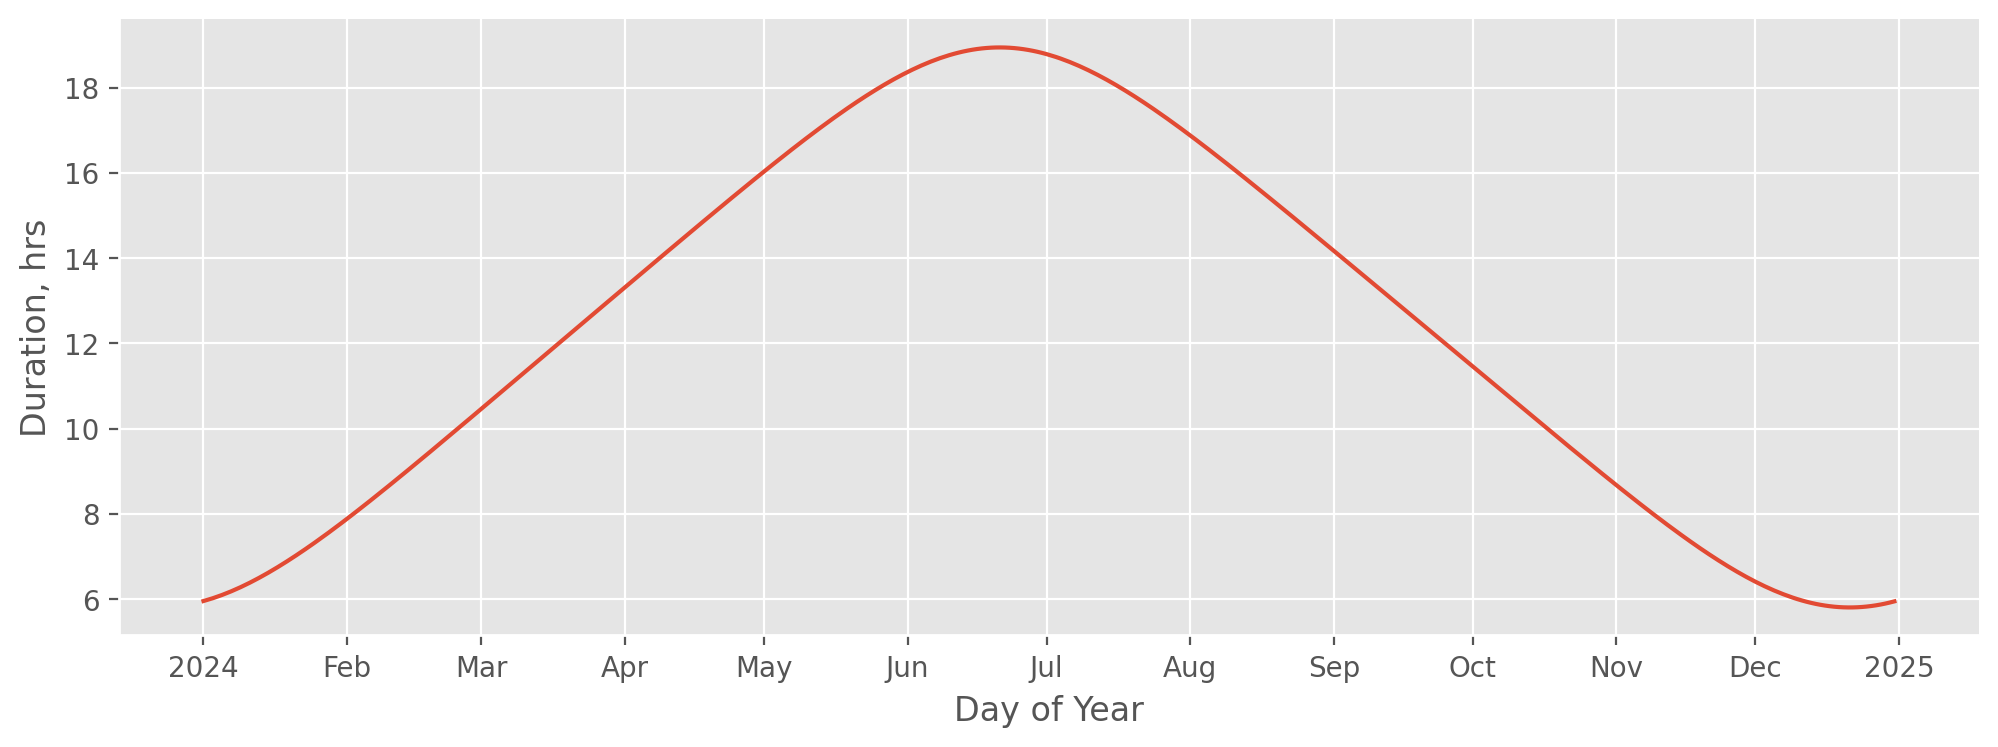

In [6]:
data = request_day_length_data(Helsinki)

xx = [d.date for d in data]
duration_yy = np.array([d.as_hours() for d in data])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xx, duration_yy)
ax.set_ylabel('Duration, hrs')
ax.set_xlabel('Day of Year')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



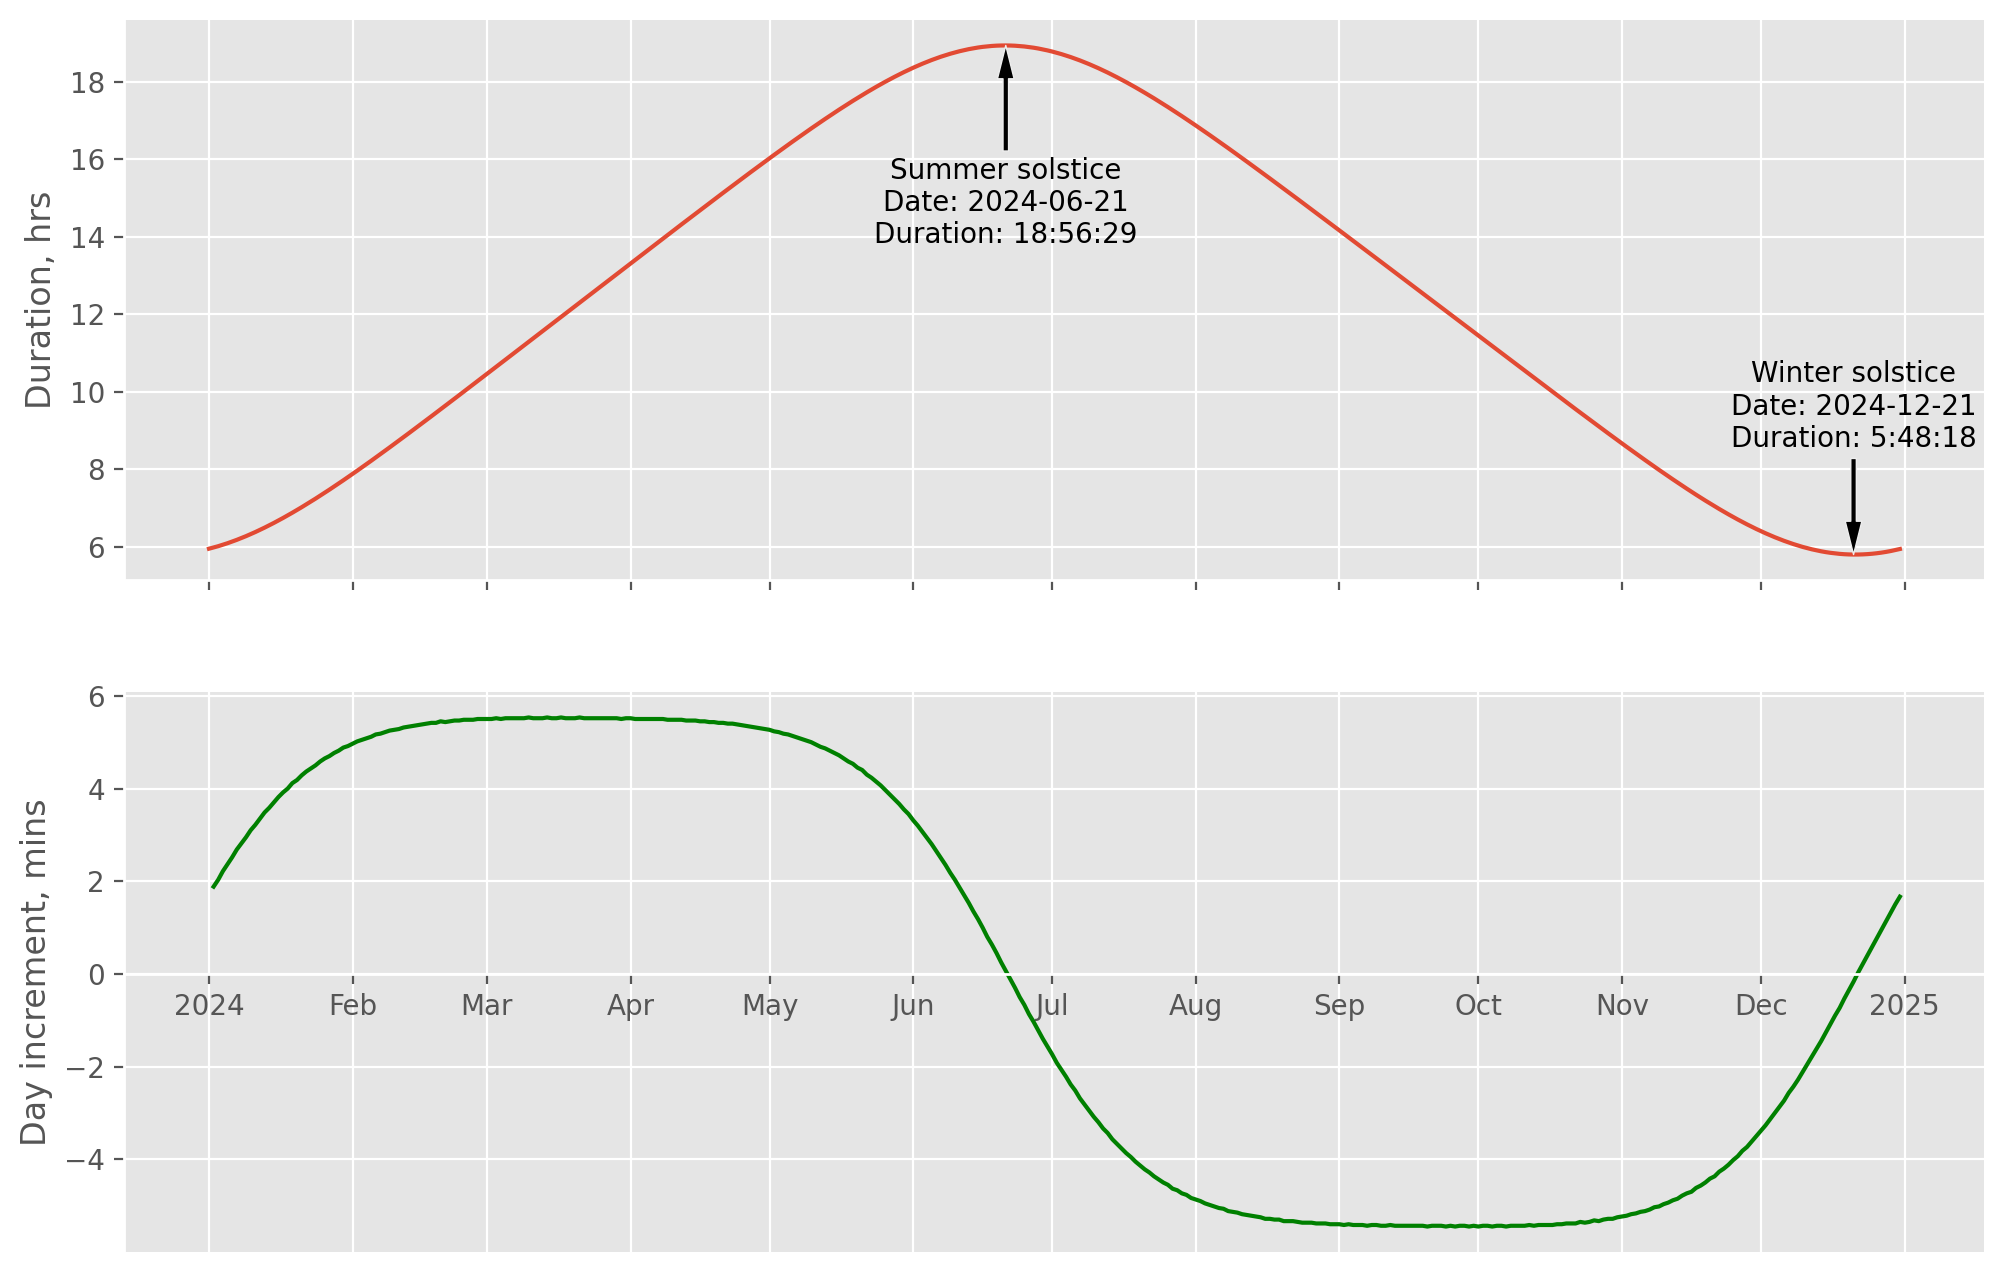

In [52]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('ggplot')

data = request_day_length_data(Helsinki)

xx = np.array([d.date for d in data])
duration_yy = np.array([d.as_hours() for d in data])
duration_incr_yy = np.ediff1d(duration_yy) * 60
summer_solstice_idx = np.argmax(duration_yy)
winter_solstice_idx = np.argmin(duration_yy)

fig, (ax1, ax2) = plt.subplots(figsize=(12, 8), nrows=2, sharex=True)

ax1.plot(xx, duration_yy)
ax1.set_ylabel('Duration, hrs')

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

summer_solstice = data[summer_solstice_idx]
winter_solstice = data[winter_solstice_idx]

ax1.annotate('Summer solstice\nDate: {}\nDuration: {}'.format(summer_solstice.date, summer_solstice.duration), 
             xy=(xx[summer_solstice_idx], duration_yy[summer_solstice_idx]), 
             xycoords='data',
             xytext=(0, -40),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6))

ax1.annotate('Winter solstice\nDate: {}\nDuration: {}'.format(winter_solstice.date, winter_solstice.duration), 
             xy=(xx[winter_solstice_idx], duration_yy[winter_solstice_idx]),
             xycoords='data',
             xytext=(0, 70),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6))


ax2.plot(xx[1:], duration_incr_yy, color='green')

ax2.set_ylabel('Day increment, mins')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position('zero')


In [59]:
max_incr = np.max(duration_incr_yy)
zone_of_hope_xx = xx[1:][duration_incr_yy > (max_incr-0.1)]
zone_of_hope_bounds = (zone_of_hope_xx[0], zone_of_hope_xx[-1])
zone_of_hope_bounds

(datetime.date(2024, 2, 20), datetime.date(2024, 4, 19))